In [1]:
# Clear the GPU
!nvidia-smi | grep 'python' | awk '{ print $5 }' | xargs -n1 kill -9
!nvidia-smi

Fri Aug 21 21:58:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:08:00.0  On |                  N/A |
| 47%   53C    P0    89W / 250W |   1347MiB / 11018MiB |     43%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# from datetime import datetime, timedelta
import glob
from math import ceil, trunc
import os
import sys
import time

import cv2

from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace
from deepface.commons import functions

from IPython.display import display, Image

import matplotlib.pyplot as plt

import numpy as np

import PIL.Image

import torch
from torchvision import utils, transforms
torch.backends.cudnn.benchmark = False

from tqdm import tqdm

# Add parent directory to path to import local files
sys.path.insert(0, '..')

from model import Generator


In [3]:
print(f"Cuda available: {torch.cuda.is_available()}")

Cuda available: True


In [4]:
# Skip cells that take a while
skip = True

## Generate random collection of images

In [5]:
# Parameters
image_size = 1024
batch_size = 1
iterations = 10000
truncation = 1
truncation_mean = 2048
ckpt = "../stylegan2-ffhq-config-f.pt"
channel_multiplier = 2
style_size = 512
n_mlp = 8
device = 'cuda'
output_folder = 'generated_faces'

try:
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
except RuntimeError as e:
    print(e)
    print(f" Can't clear cuda, ignoring.")

os.makedirs(output_folder, exist_ok=True)

generator_model = Generator(image_size, style_size, n_mlp, channel_multiplier=channel_multiplier).to(device)
checkpoint = torch.load(ckpt, map_location=lambda storage, loc: storage)

generator_model.load_state_dict(checkpoint['g_ema'])
generator_model.to(device=device)

if truncation < 1:
    with torch.no_grad():
        mean_latent = generator_model.mean_latent(truncation_mean)
else:
    mean_latent = None


### Generation loop

In [6]:
if not skip:
    current_face = 0
    with torch.no_grad():
        generator_model.eval()
        for iteration in tqdm(range(iterations)):
            random_latent_tensors = torch.randn(batch_size, style_size, device=device)

            faces, _ = generator_model([random_latent_tensors], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)

            object_path = f"{output_folder}/{str(current_face).zfill(6)}"
            for random_latent_tensor in random_latent_tensors:
                torch.save(random_latent_tensor, f"{object_path}_latent.pt")
            for face in faces:
                utils.save_image(
                    face,
                    f"{object_path}.png",
                    nrow=1,
                    normalize=True,
                    range=(-1, 1),
                )
                current_face += 1


## Random walk over latent space

In [7]:
def get_style_tensor(key):
    object_path = f"{output_folder}/{str(key).zfill(6)}"
    
    style_tensor = torch.load(f"{object_path}_latent.pt")
    return style_tensor

In [8]:
# if not skip:
#     # Get image to perform random walk on.
#     #     NOTE: We get two of the same image because pixelnorm (pseudo batch norm) requires 2 inputs.
#     #           Could be fixed but this work around is easy enough
#     style_tensors = torch.stack((get_style_tensor(4), get_style_tensor(4)))

#     num_faces = 50
#     change_rate = 0.5
#     files = []
#     os.makedirs("tmp", exist_ok=True)

#     torch.cuda.empty_cache()
#     torch.cuda.ipc_collect()

#     for i in range(num_faces):
#         style_tensors[0] = style_tensors[0] + change_rate * (torch.rand(style_tensors[0].size()) - 0.5).to(device)
#         faces, _ = generator_model([style_tensors.to(device)], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)

#         file = f"tmp/{str(i).zfill(6)}.png"
#         files.append(file)
#         utils.save_image(
#             faces[0],
#             file,
#             nrow=1,
#             normalize=True,
#             range=(-1, 1),
#         )

#     # Create gif
#     pil_images = []
#     for file in files:
#         pil_images.append(PIL.Image.open(file).resize((512, 512), PIL.Image.ANTIALIAS))

#     pil_images.extend(pil_images[-2::-1])
#     pil_images[0].save('tmp/gif.gif',
#                    save_all=True, append_images=pil_images, optimize=False, duration=40, loop=0, quality=15)


In [9]:
def get_image_path(key, folder):
    return f"{folder}/{str(key).zfill(6)}.png"

def get_image_blob(key, folder):
    img1 = functions.detectFace(get_image_path(key, folder), target_size=(96, 96))[0]
    return cv2.dnn.blobFromImage(img1)

model = cv2.dnn.readNetFromTorch("/home/g/Documents/projects/stylegan2-pytorch/openface_models/nn4.small2.v1.t7") 

def get_representation(key, folder = "tmp"):
    blob = get_image_blob(key, folder)
    model.setInput(blob)
    
    return model.forward()


In [10]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance   

In [11]:
def display_image(key, display_size = 256, folder = "tmp"):
    object_path = f"{folder}/{str(key).zfill(6)}"
    display(Image(f"{object_path}.png", width = display_size, height = display_size))


In [12]:
def get_representation_raw(path):
    img1 = functions.detectFace(path, target_size=(96, 96))[0]
    blob = cv2.dnn.blobFromImage(img1)
    model.setInput(blob)
    
    return torch.tensor(model.forward())


In [13]:
if not skip:
    start = 2
    max_iterations = 100
    threshold = 0.6
    for i in range(start, start + max_iterations + 1):
        distance = findEuclideanDistance(get_representation(start), get_representation(i))
        print(f"{i} distance: {distance}")
        if distance > threshold:
            print(f"Sample #{start} evolved to new person at sample #{i}")
            display_image(start)
            display_image(i)
            break

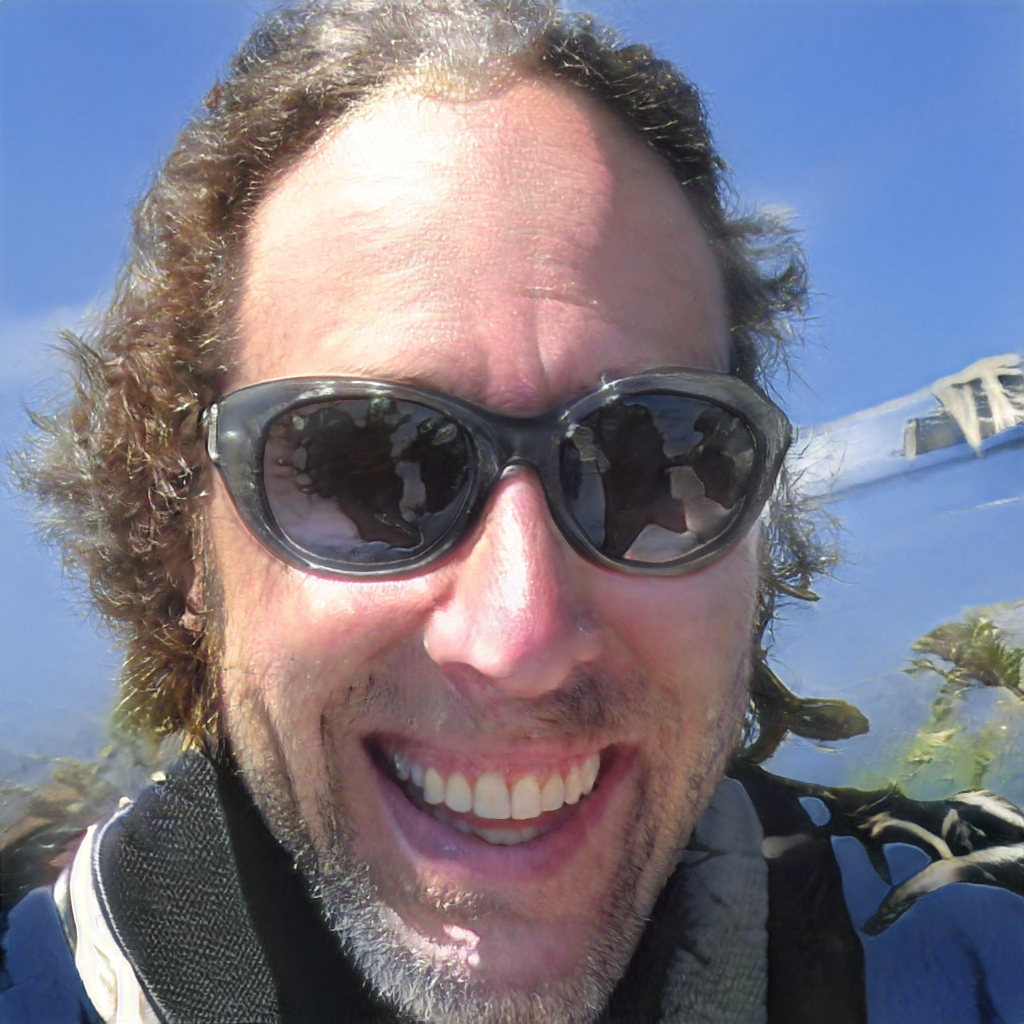

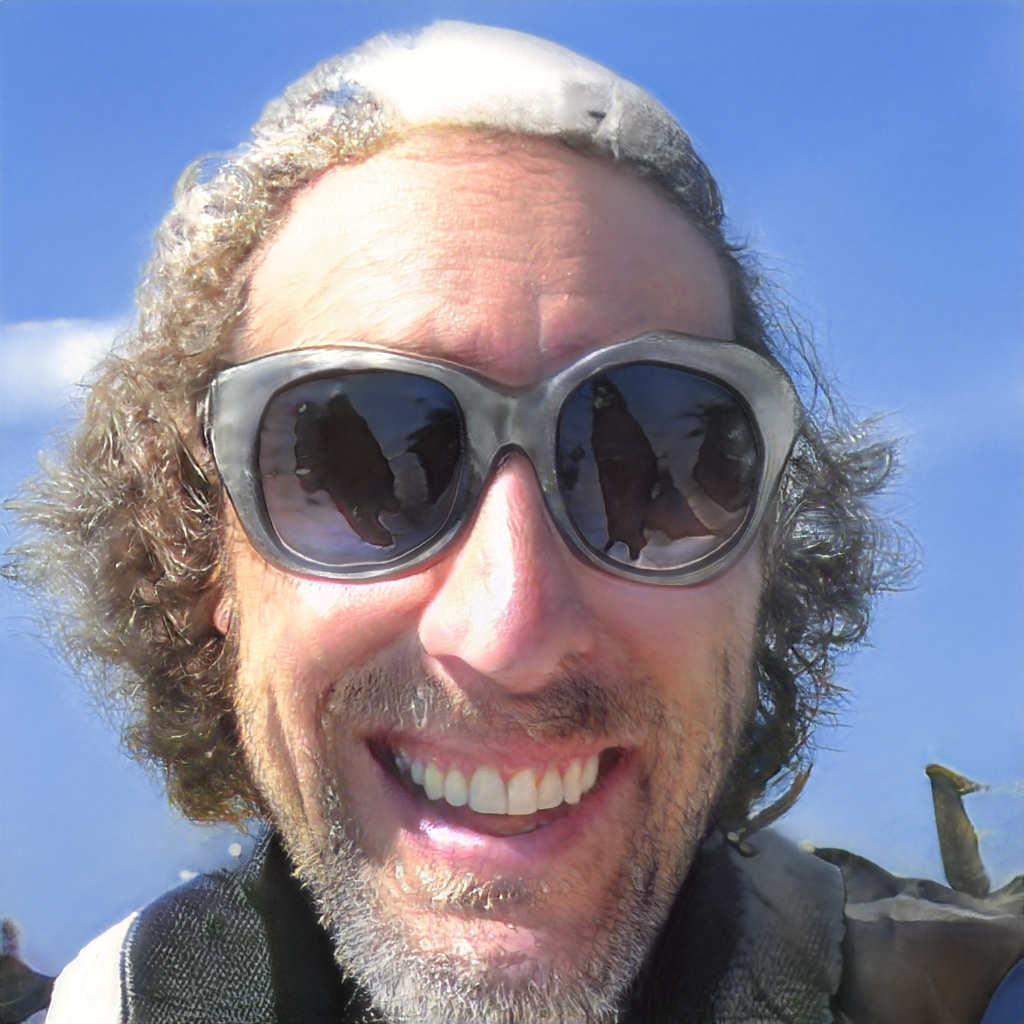

In [14]:
display_image(2)
display_image(5)

## Map a given open face representation to StyleGAN latent space

### Get OpenFace representation for images

In [15]:
def get_image_blob(face_path):
    print(f"Processing {face_path}")
    image = functions.detectFace(face_path, target_size=(96, 96))[0]
    return cv2.dnn.blobFromImage(image)

model = cv2.dnn.readNetFromTorch("/home/g/Documents/projects/stylegan2-pytorch/openface_models/nn4.small2.v1.t7") 
def get_representation(face_path):
    blob = get_image_blob(face_path)
    model.setInput(blob)
    return model.forward()


In [16]:
pruned_folder = "pruned_generated_faces"


In [17]:
if not skip:
    os.makedirs(pruned_folder, exist_ok=True)

    face_paths = glob.glob(f"{output_folder}/*.png")

    prune_count = 0
    for face_path in face_paths:
        try:
            open_face_representation = get_representation(face_path)
        except (ValueError, AttributeError) as e:
            print(f"  {e}")
            print(f"  Skipping {face_path}, it's a low quality face")

            # Prune low quality face
            for f in glob.glob(f"{os.path.splitext(face_path)[0]}*"):
                print(f"    Pruning {f}")
                os.rename(f, f"{pruned_folder}/{os.path.split(f)[1]}")

            prune_count += 1
            continue

        # Process and convert into torch tensor
        open_face_tensor = torch.from_numpy(open_face_representation.squeeze())

        filename = f"{os.path.splitext(face_path)[0]}_ofr.pt"
        torch.save(open_face_tensor, filename)
    print(f"Complete.  Pruned total of {prune_count} faces.")


In [18]:
def print_face(style_tensors, device=device):
    faces, _ = generator_model([style_tensors.to(device)], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)

    file = f"tmp/tmp.png"
    utils.save_image(
        faces[0],
        file,
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )

    display(Image(file, width = 256, height = 256))

### Create dataset

In [19]:
# Dataset settings
train_test_proportion = 0.9
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 0}


In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, output_folder = "generated_faces"):
        self.data = []
        
        face_paths = glob.glob(f"{output_folder}/*[!projection].png")
        for face_path in face_paths:
            base_path = os.path.splitext(face_path)[0]

            ofr_path = f"{base_path}_ofr.pt"
            ofr_tensor = torch.load(ofr_path).requires_grad_()
 
            self.data.append((ofr_tensor, base_path))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


In [21]:
if 'dataset' in locals():
    del dataset

dataset = Dataset()

train_size = int(train_test_proportion * len(dataset))
test_size = len(dataset) - train_size
training_dataset, testing_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

training_generator = torch.utils.data.DataLoader(training_dataset, **params)
testing_generator = torch.utils.data.DataLoader(testing_dataset, **params)


In [22]:
print(f"dataset len:          {len(dataset)}")
print(f"training_dataset len: {len(training_dataset)}")
print(f"testing_dataset len:  {len(testing_dataset)}")

dataset len:          8444
training_dataset len: 7599
testing_dataset len:  845


### Loss function

In [23]:
model = cv2.dnn.readNetFromTorch("/home/g/Documents/projects/stylegan2-pytorch/openface_models/nn4.small2.v1.t7")
def get_representation(face_tensor):
    # Normalize face
    from_face_tensor = utils.make_grid(face_tensor.detach(), normalize = True, range=(-1, 1))
    from_face_tensor = from_face_tensor.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    
    # Convert to np array in expected output format
    from_face_tensor = PIL.Image.fromarray(from_face_tensor)
    from_face_tensor = np.array(from_face_tensor)
    
    try:
        preprocessed_image = functions.detectFace(from_face_tensor, target_size=(96, 96))[0]
        blob = cv2.dnn.blobFromImage(preprocessed_image)

        # Get ofr from face blob
        model.setInput(blob)
        face_representation = model.forward()
#         print("Good face!", flush = True)
        return torch.from_numpy(face_representation).squeeze().to(device=device)

    except ValueError:
#         print("Poor quality face, skipping.", flush = True)
        return None


In [24]:
# model = cv2.dnn.readNetFromTorch("/home/g/Documents/projects/stylegan2-pytorch/openface_models/nn4.small2.v1.t7")
# def get_representation(face_tensor):
#     file = f"get_representation/tmp.png"
#     utils.save_image(
#         face_tensor,
#         file,
#         nrow=1,
#         normalize=True,
#         range=(-1, 1),
#     )
#     try:
#         preprocessed_image = functions.detectFace(file, target_size=(96, 96))[0]
#         blob = cv2.dnn.blobFromImage(preprocessed_image)

#         # Get ofr from face blob
#         model.setInput(blob)
#         face_representation = model.forward()

#         return torch.from_numpy(face_representation).squeeze().to(device=device)

#     except ValueError:
#         return None


In [25]:
# Test the above
torch.cuda.empty_cache()
style_tensors = torch.zeros(5, 512).to(device=device)
faces, _ = generator_model([style_tensors], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)
get_representation(faces[0]).shape

/home/g/Documents/projects/stylegan2-pytorch/venv_environment/lib/python3.8/site-packages/deepface-0.0.35.greg_custom-py3.8.egg/deepface/commons/functions.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if len(img) > 11 and img[0:11] == "data:image/":


torch.Size([128])

In [26]:
# invalid_face_penalty = torch.tensor(3., requires_grad=True).to(device=device)
# mse_loss = torch.nn.MSELoss()
# def loss_function(style_tensors, target_ofrs):
    
#     # Convert style_tensors to pictures of faces
#     faces, _ = generator_model([style_tensors], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)

#     # Get ofrs of the faces
#     actual_ofrs = []
#     for face in faces:
#         representation = get_representation(face)
#         actual_ofrs.append(representation)
    
# #     actual_ofrs = torch.stack(actual_ofrs).to(device=device)
#     running_mse = 0.
#     for actual_ofr, target_ofr in zip(actual_ofrs, target_ofrs):
#         if actual_ofr == None:
#             running_mse += invalid_face_penalty
#         else:
#             running_mse += mse_loss(actual_ofr, target_ofr) * 128
#     running_mse /= len(actual_ofrs)
#     # print(f"actual_ofrs: {actual_ofrs.size()} {actual_ofrs.device} target_ofrs: {target_ofrs.size()} {target_ofrs.device}")
#     # Compare actual_ofrs to target_ofrs
#     return running_mse


In [27]:
# # Debug instrumented loss
# gen_batch_size = 4
# invalid_face_penalty = torch.tensor(3., requires_grad=True).to(device=device)
# mse_loss = torch.nn.MSELoss()

# max_loss = 0.
# min_loss = float("inf")
# def loss_function(style_tensors, target_ofrs, base_paths):
#     global max_loss
#     global min_loss
# #     torch.cuda.empty_cache()
#     # Convert style_tensors to pictures of faces
#     faces = []
#     # Takes insane amount of memory, generate in smaller batches
#     for style_tensor in torch.split(style_tensors, gen_batch_size):
#         face, _ = generator_model([style_tensor], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)
# #         torch.cuda.empty_cache()
#         faces.extend([f for f in face])
    
#     # Get ofrs of the faces
#     actual_ofrs = []
#     for face in faces:
#         representation = get_representation(face)
#         actual_ofrs.append(representation)
    
#     running_mse = 0.
#     for actual_ofr, target_ofr, base_path, face in zip(actual_ofrs, target_ofrs, base_paths, faces):
#         if actual_ofr == None:
#             running_mse += invalid_face_penalty
#         else:
#             # Compare actual_ofrs to target_ofrs
#             loss = mse_loss(actual_ofr, target_ofr) * 128
#             if loss > max_loss:
#                 max_loss = loss
#                 print(f"  new max_loss: {max_loss}")
#             if loss < min_loss:
#                 min_loss = loss
#                 print(f"  new min_loss: {min_loss} for {base_path}")
#                 utils.save_image(
#                     face,
#                     f"{base_path}_projection.png",
#                     nrow=1,
#                     normalize=True,
#                     range=(-1, 1),
#                 )
#             running_mse += loss
            
#     running_mse /= len(actual_ofrs)
    
#     return running_mse


In [28]:
gen_batch_size = 4
invalid_face_penalty = torch.tensor(3., requires_grad=True).to(device=device)
mse_loss = torch.nn.MSELoss()

def loss_function(style_tensors, target_ofrs, base_paths = None):
    global max_loss
    global min_loss
#     torch.cuda.empty_cache()
    # Convert style_tensors to pictures of faces
    faces = []
    # Takes insane amount of memory, generate in smaller batches
    for style_tensor in torch.split(style_tensors, gen_batch_size):
        face, _ = generator_model([style_tensor], truncation=truncation, truncation_latent=mean_latent, input_is_latent=False)
#         torch.cuda.empty_cache()
        faces.extend([f for f in face])
    
    # Get ofrs of the faces
    actual_ofrs = []
    for face in faces:
        representation = get_representation(face)
        actual_ofrs.append(representation)
    
    running_mse = 0.
    for actual_ofr, target_ofr, face in zip(actual_ofrs, target_ofrs, faces):
        if actual_ofr == None:
            running_mse += invalid_face_penalty
        else:
            # Compare actual_ofrs to target_ofrs
            loss = mse_loss(actual_ofr, target_ofr) * 128
            running_mse += loss
            
    running_mse /= len(actual_ofrs)
    
    return running_mse


### Create model

In [29]:
# Model settings
dropout= 0.5
input_size = training_dataset[0][0].size(0)

# model_file_name = "mlp_final.pt"
# model_file_name = "mlp3.pt"
# model_file_name = "mlp_f.pt"
model_file_name = "mlp_beast"

print(f"input_size:  {input_size}")

input_size:  128


In [30]:
len(training_dataset)

7599

In [31]:
len(training_generator)

1900

In [32]:
it = iter(training_generator)
ttl = 0
for n in it:
    ttl += len(n)
print(f"ttl: {ttl}")

ttl: 3800


In [33]:
# # mlp_new
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = int(input_size + output_size / 2)
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, input_size)
#         self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
#         self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_3 = torch.nn.Linear(hidden_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden1_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
#         hidden2_ret = self.dropout_layer(self.hidden_layer_2(hidden1_ret))
#         hidden3_ret = self.dropout_layer(self.hidden_layer_3(hidden2_ret))
#         output_ret = self.output_layer(hidden3_ret)
        
#         return output_ret


In [34]:
# # mlp_new_new
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = output_size * 2
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, input_size)
#         self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
#         self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_3 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_4 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_5 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_6 = torch.nn.Linear(hidden_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden1_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
#         hidden2_ret = self.dropout_layer(self.hidden_layer_2(hidden1_ret))
#         hidden3_ret = self.dropout_layer(self.hidden_layer_3(hidden2_ret))
#         hidden4_ret = self.dropout_layer(self.hidden_layer_4(hidden3_ret))
#         hidden5_ret = self.dropout_layer(self.hidden_layer_5(hidden4_ret))
#         hidden6_ret = self.dropout_layer(self.hidden_layer_6(hidden5_ret))
#         output_ret = self.output_layer(hidden6_ret)
        
#         return output_ret


In [35]:
# # mlp#
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = int(input_size + output_size / 2)
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, input_size)
#         self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
#         output_ret = self.output_layer(hidden_ret)
        
#         return output_ret


In [36]:
# # mlp_final
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = output_size
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, hidden_size)
#         self.hidden_layer_1 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden_ret1 = self.dropout_layer(self.hidden_layer_1(input_ret))
#         hidden_ret2 = self.dropout_layer(self.hidden_layer_2(hidden_ret1))
#         output_ret = self.output_layer(hidden_ret2)
        
#         return output_ret


In [37]:
# # mlp_f
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = output_size
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, input_size)
#         self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
#         self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_3 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_4 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_5 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_6 = torch.nn.Linear(hidden_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden1_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
#         hidden2_ret = self.dropout_layer(self.hidden_layer_2(hidden1_ret))
#         hidden3_ret = self.dropout_layer(self.hidden_layer_3(hidden2_ret))
#         hidden4_ret = self.dropout_layer(self.hidden_layer_4(hidden3_ret))
#         hidden5_ret = self.dropout_layer(self.hidden_layer_5(hidden4_ret))
#         hidden6_ret = self.dropout_layer(self.hidden_layer_6(hidden5_ret))
#         output_ret = self.output_layer(hidden6_ret)
        
#         return output_ret


In [38]:
# # mlp_f
# class MLP(torch.nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MLP, self).__init__()
        
#         hidden_size = output_size
        
#         # Make layers
#         self.dropout_layer = torch.nn.Dropout(dropout)
#         self.input_layer = torch.nn.Linear(input_size, input_size)
#         self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
#         self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_3 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_4 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_5 = torch.nn.Linear(hidden_size, hidden_size)
#         self.hidden_layer_6 = torch.nn.Linear(hidden_size, hidden_size)
#         self.output_layer = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         input_ret = self.dropout_layer(self.input_layer(input))
#         hidden1_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
#         hidden2_ret = self.dropout_layer(self.hidden_layer_2(hidden1_ret))
#         hidden3_ret = self.dropout_layer(self.hidden_layer_3(hidden2_ret))
#         hidden4_ret = self.dropout_layer(self.hidden_layer_4(hidden3_ret))
#         hidden5_ret = self.dropout_layer(self.hidden_layer_5(hidden4_ret))
#         hidden6_ret = self.dropout_layer(self.hidden_layer_6(hidden5_ret))
#         output_ret = self.output_layer(hidden6_ret)
        
#         return output_ret


In [39]:
# mlp_beast
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(MLP, self).__init__()
        
        hidden_size = output_size * 6
        
        # Make layers
        self.dropout_layer = torch.nn.Dropout(dropout)
        self.input_layer = torch.nn.Linear(input_size, input_size)
        self.hidden_layer_1 = torch.nn.Linear(input_size, hidden_size)
        self.hidden_layer_2 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_3 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_4 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_5 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_6 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_7 = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_layer_8 = torch.nn.Linear(hidden_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input):
        input_ret = self.dropout_layer(self.input_layer(input))
        hidden1_ret = self.dropout_layer(self.hidden_layer_1(input_ret))
        hidden2_ret = self.dropout_layer(self.hidden_layer_2(hidden1_ret))
        hidden3_ret = self.dropout_layer(self.hidden_layer_3(hidden2_ret))
        hidden4_ret = self.dropout_layer(self.hidden_layer_4(hidden3_ret))
        hidden5_ret = self.dropout_layer(self.hidden_layer_5(hidden4_ret))
        hidden6_ret = self.dropout_layer(self.hidden_layer_6(hidden5_ret))
        hidden7_ret = self.dropout_layer(self.hidden_layer_7(hidden6_ret))
        hidden8_ret = self.dropout_layer(self.hidden_layer_8(hidden7_ret))
        output_ret = self.output_layer(hidden8_ret)
        
        return output_ret


In [40]:
mlp = MLP(input_size, 512, dropout)

if os.path.isfile(model_file_name):
    mlp.load_state_dict(torch.load(model_file_name))
else:
    print(f"No model named '{model_file_name}' currently exists.")

mlp = mlp.to(device = device)


In [41]:
# Test a few inputs
print(mlp.forward(training_dataset[0][0].to(device = device)).size())
print( mlp.forward(next(iter(training_generator))[0].to(device = device)).size() )

torch.Size([512])
torch.Size([4, 512])


In [42]:
# Training settings
num_epochs = 10000
learning_rate = 1000
weight_decay = 0.


In [43]:
# Set up optimizer and loss functions
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [44]:
# # CHECK SAVED MODELS AGAINST TEST SET
# # model_file_name = 'mlp3.pt'

# mlp = MLP(input_size, 512, dropout)
# mlp.load_state_dict(torch.load(model_file_name))
# mlp = mlp.to(device = device)

# optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

# mlp.eval()

# testing_running_loss = 0.
# batch_num = 1
# with torch.no_grad():
#     for batch in testing_generator:
#         torch.cuda.empty_cache()

#         print(f"  Processing testing batch  # {batch_num}/{len(testing_generator)}")

#         batch = batch.to(device = device)

#         optimizer.zero_grad()

#         # Pass into models
#         model_actual_output = mlp(batch)

#         loss = loss_function(model_actual_output, batch)
#         testing_running_loss += loss.item()

#         batch_num += 1

# testing_loss = testing_running_loss / len(testing_generator)

# print(f"Completed. Loss: {testing_loss}")


In [45]:
# # Find ideal learning rate
# from torch_lr_finder import LRFinder
# train_size = 5000
# min_lr = 1e-50
# max_lr = 100

# class LrDataset(torch.utils.data.Dataset):
#     def __init__(self, output_folder = "generated_faces"):
#         self.data = []
        
#         face_paths = glob.glob(f"{output_folder}/*[!projection].png")
#         for face_path in face_paths:
#             base_path = os.path.splitext(face_path)[0]

#             ofr_path = f"{base_path}_ofr.pt"
#             ofr_tensor = torch.load(ofr_path).requires_grad_()

#             self.data.append(ofr_tensor)
    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         return (self.data[index], self.data[index])

# if 'dataset' in locals():
#     del dataset

# dataset = LrDataset()


# training_dataset, _ = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

# training_generator = torch.utils.data.DataLoader(training_dataset, **params)

# input_size = training_dataset[0][0].size(0)



# mlp = MLP(input_size, 512, 0.)
# mlp.load_state_dict(torch.load(model_file_name))
# mlp = mlp.to(device = device)
# mlp.eval()

# optimizer = torch.optim.Adam(mlp.parameters(), lr=min_lr, weight_decay=0.0)
# lr_finder = LRFinder(mlp, optimizer, loss_function, device="cuda")
# lr_finder.range_test(training_generator, end_lr=max_lr, num_iter=100)
# lr_finder.plot(show_lr = 1e-17)
# # lr_finder.reset()


In [46]:
# lr_finder.plot(show_lr = 2e-16)

In [47]:
skip = False

In [ ]:
if not skip:
    torch.cuda.empty_cache()

    best_testing_value = sys.float_info.max
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, verbose=True)
    
    testing_loss_list = []
    training_loss_list = []

    # Start training
    print('Starting...')
    for i in range(num_epochs):
        start_time = time.time()
        
        # Load best version of model
        if os.path.isfile(model_file_name):
            mlp.load_state_dict(torch.load(model_file_name))
        else:
            print(f"No model named '{model_file_name}' currently exists.")
        
        torch.cuda.empty_cache()

        # Statistics to collect
        training_running_loss = 0.
        testing_running_loss = 0.

        # Train model with training batch
        mlp.train()
        batch_num = 1
        for batch, base_paths in training_generator:
            torch.cuda.empty_cache()
            
#             print(f"  Processing training batch # {batch_num}/{len(training_generator)}")

            batch = batch.to(device = device)

            optimizer.zero_grad()

            # Pass into models
            model_actual_output = mlp(batch)

            torch.cuda.empty_cache()
            loss = loss_function(model_actual_output, batch, base_paths)
            training_running_loss += loss.item()

            loss.backward()
            optimizer.step()
            
            if batch_num % 25 == 0:
                print(f'      Training average loss so far: {training_running_loss / batch_num}', flush = True)
                print(f'      Batch {batch_num} / {len(training_generator)}', flush = True)            
            batch_num += 1

        # Test model with testing batch
        mlp.eval()
        batch_num = 1
        with torch.no_grad():
            for batch, base_paths in testing_generator:
                torch.cuda.empty_cache()
                
#                 print(f"  Processing testing batch  # {batch_num}/{len(testing_generator)}")
                
                batch = batch.to(device = device)

                optimizer.zero_grad()

                # Pass into models
                model_actual_output = mlp(batch)

                torch.cuda.empty_cache()
                loss = loss_function(model_actual_output, batch, base_paths)
                testing_running_loss += loss.item()

                batch_num += 1

        training_loss = training_running_loss / len(training_generator)
        testing_loss = testing_running_loss / len(testing_generator)
        
        scheduler.step(testing_loss)
        
        training_loss_list.append(training_loss)
        testing_loss_list.append(testing_loss)
        
        if testing_loss < best_testing_value:
            print(f"New best training value of {testing_loss}! Previous best was {best_testing_value}.  Saving model...", flush = True)
            best_testing_value = testing_loss
            torch.save(mlp.state_dict(), model_file_name)
            
            f = open(f"{os.path.splitext(model_file_name)[0]}_info.txt", "w")
            f.writelines([f"epoch:         {i}",             "\n",
                          f"testing_loss:  {testing_loss}",  "\n",
                          f"training_loss: {training_loss}", "\n",
                         ])
            
            f.close()
        
        # Print results
        print(f'Epoch: {i:3}', flush = True)
        print(f'    Time elapsed: {time.time() - start_time} sec', flush = True)
        print(f'    Training average loss: {training_loss}', flush = True)
        print(f'    Testing average loss:  {testing_loss}', flush = True)
    print("Complete.")

    plt.plot(training_loss_list)
    plt.ylabel('Training Loss')
    plt.show()

    plt.plot(testing_loss_list)
    plt.ylabel('Testing Loss')
    plt.show()

Starting...
      Training average loss so far: 1.9833253049850463
      Batch 25 / 1900
      Training average loss so far: 1.9442212462425232
      Batch 50 / 1900
      Training average loss so far: 1.8891633701324464
      Batch 75 / 1900
      Training average loss so far: 1.91578022480011
      Batch 100 / 1900
      Training average loss so far: 1.923335618019104
      Batch 125 / 1900
      Training average loss so far: 1.8992961875597636
      Batch 150 / 1900
      Training average loss so far: 1.8848802832194738
      Batch 175 / 1900
      Training average loss so far: 1.8856088942289353
      Batch 200 / 1900
      Training average loss so far: 1.8894252506891887
      Batch 225 / 1900
      Training average loss so far: 1.8898155608177185
      Batch 250 / 1900
      Training average loss so far: 1.8756023322452198
      Batch 275 / 1900
      Training average loss so far: 1.8815484889348348
      Batch 300 / 1900
      Training average loss so far: 1.876702247766348
    

In [ ]:
plt.plot(testing_loss_list)
plt.ylabel('Testing Loss')
plt.show()

In [ ]:
mlp = MLP(input_size, 512, dropout)
mlp.load_state_dict(torch.load(model_file_name))
mlp.eval()
mlp = mlp.to(device = device)

In [ ]:
me_representation = get_representation_raw("garbage/me.png").squeeze()
print(me_representation.size())
torch.save(me_representation.squeeze(), "garbage/me_ofr.pt")

In [ ]:
batch = torch.stack((me_representation, me_representation.clone())).to(device=device)

In [ ]:
# Let's see how well this model worked.  I'm guessing poorly.
latent = mlp.forward(batch)

In [ ]:
# Yup, poorly.  We need a custom loss function.
print_face(latent)